In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [7]:
file = open('insurance.csv', 'r')
reader = csv.reader(file)
data = []

for row in reader:
	data.append(row)
print(data.pop(0))
data = np.array(data)

data[:, 1][data[:, 1] == 'male'] = 0
data[:, 1][data[:, 1] == 'female'] = 1
data[:, 4][data[:, 4] == 'no'] = 0
data[:, 4][data[:, 4] == 'yes'] = 1
data[:, 5][data[:, 5] == 'northeast'] = 0
data[:, 5][data[:, 5] == 'northwest'] = 1
data[:, 5][data[:, 5] == 'southeast'] = 2
data[:, 5][data[:, 5] == 'southwest'] = 3
data = data.astype(np.float64)

#normalize data
for i in range(len(data[0])):
	std = np.std(data[:,i])
	data[:,i] = data[:,i] - np.mean(data[:,i])
	data[:,i] = data[:,i]/std

x_data = data[:, :6]#.reshape((len(data), 6, 1))
y_data = data[:, 6]
print(x_data.shape)
print(y_data.shape)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
(1338, 6)
(1338,)


In [8]:
# N = len(data)
# alpha = 2.3
# sigma = 2.
# slope = 4.
# x = np.random.normal (size=N)
# y = alpha + slope * x + sigma * np.random.normal(size=N)

data = {
	'N': len(data),
	'K': len(x_data[0]),
    'x': x_data,
    'y': y_data
}

In [9]:
program_code = """
data {
  int<lower=1> N;           // Number of samples
  int<lower=1> K;           // Number of predictors
  matrix[N, K] x;              // Covariate
  vector[N] y;              // Outcome
}

parameters {
  real alpha;               // Intercept
  row_vector[K] beta;       // Slope
  real<lower=0> sigma;      // Noise
}

model {
  // Priors
  sigma ~ inv_gamma(1, 1);     //tau0 = 1, tau1 = 1
  alpha ~ normal(0, 10);       //sigma_alhpa = 10
  beta ~ multi_normal(rep_vector(0, K), diag_matrix(rep_vector(10, K)));  //sigma_beta = 10

  // Likelihood
  for (n in 2:N)
    y[n] ~ normal(alpha + beta * x[n]', sigma);
}
"""

In [10]:
model = stan.build(program_code,data)
fit = model.sample(num_chains=3,num_warmup=1000,num_samples=2500)

Building...

In file included from /Users/michaelchen/Library/Caches/httpstan/4.12.0/models/ffxo6bsk/model_ffxo6bsk.cpp:2:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /opt/anaconda3/lib/python3.11/site-packages/httpstan/include/Eigen/SparseCore:61:
/opt/anaconda3/lib/python3.11/site-packages/httpstan/include/Eigen/src/SparseCore/TriangularSolver.h:273:13: warning: variable 'count' set but not used [-Wunused-but-set-variable]
      Index count = 0;
            ^
In file included from /Users/micha

4 warnings generated.
ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: object file (/opt/anaconda3/lib/python3.11/site-packages/httpstan/stan_services.o) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/opt/anaconda3/lib/python3.11/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-11.0-arm64-cpython-311/Users/michaelchen/Library/Caches/httpstan/4.12.0/models/ffxo6bsk/model_ffxo6bsk.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/opt/anaconda3/lib/python3.11/si

In [11]:
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta.1,beta.2,beta.3,beta.4,beta.5,beta.6,sigma
draws,,,,,,,,,,,,,,,
0,257.183882,0.920855,0.621047,3.0,7.0,0.0,-252.284448,0.013381,0.300275,0.018727,0.176393,0.030273,0.796518,-0.025946,0.504923
1,255.802467,0.938842,0.764956,3.0,7.0,0.0,-250.552215,0.014215,0.301762,-0.002829,0.176624,0.023049,0.788753,-0.017401,0.493841
2,255.416230,0.972807,0.724797,3.0,7.0,0.0,-252.977300,-0.003126,0.284331,-0.016240,0.178789,0.039608,0.778445,-0.017299,0.507875
3,254.215594,0.815908,0.621047,3.0,7.0,0.0,-252.423883,-0.015756,0.288364,-0.002877,0.151751,0.075240,0.797905,-0.048187,0.508045
4,256.854154,0.848996,0.764956,3.0,7.0,0.0,-252.249747,-0.012916,0.301454,0.010396,0.154617,0.061891,0.784970,-0.026396,0.510586


In [12]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.014,-0.026,0.025,0.0,0.0,12275.0,4692.0,1.0
beta[0],0.298,0.014,0.271,0.323,0.0,0.0,11171.0,6086.0,1.0
beta[1],0.006,0.014,-0.020,0.032,0.0,0.0,11775.0,5934.0,1.0
beta[2],0.167,0.014,0.142,0.194,0.0,0.0,10882.0,5646.0,1.0
beta[3],0.047,0.014,0.022,0.074,0.0,0.0,12101.0,5932.0,1.0
beta[4],0.795,0.014,0.770,0.821,0.0,0.0,12149.0,6142.0,1.0
beta[5],-0.032,0.014,-0.057,-0.005,0.0,0.0,11302.0,5786.0,1.0
sigma,0.501,0.010,0.482,0.519,0.0,0.0,10724.0,5592.0,1.0


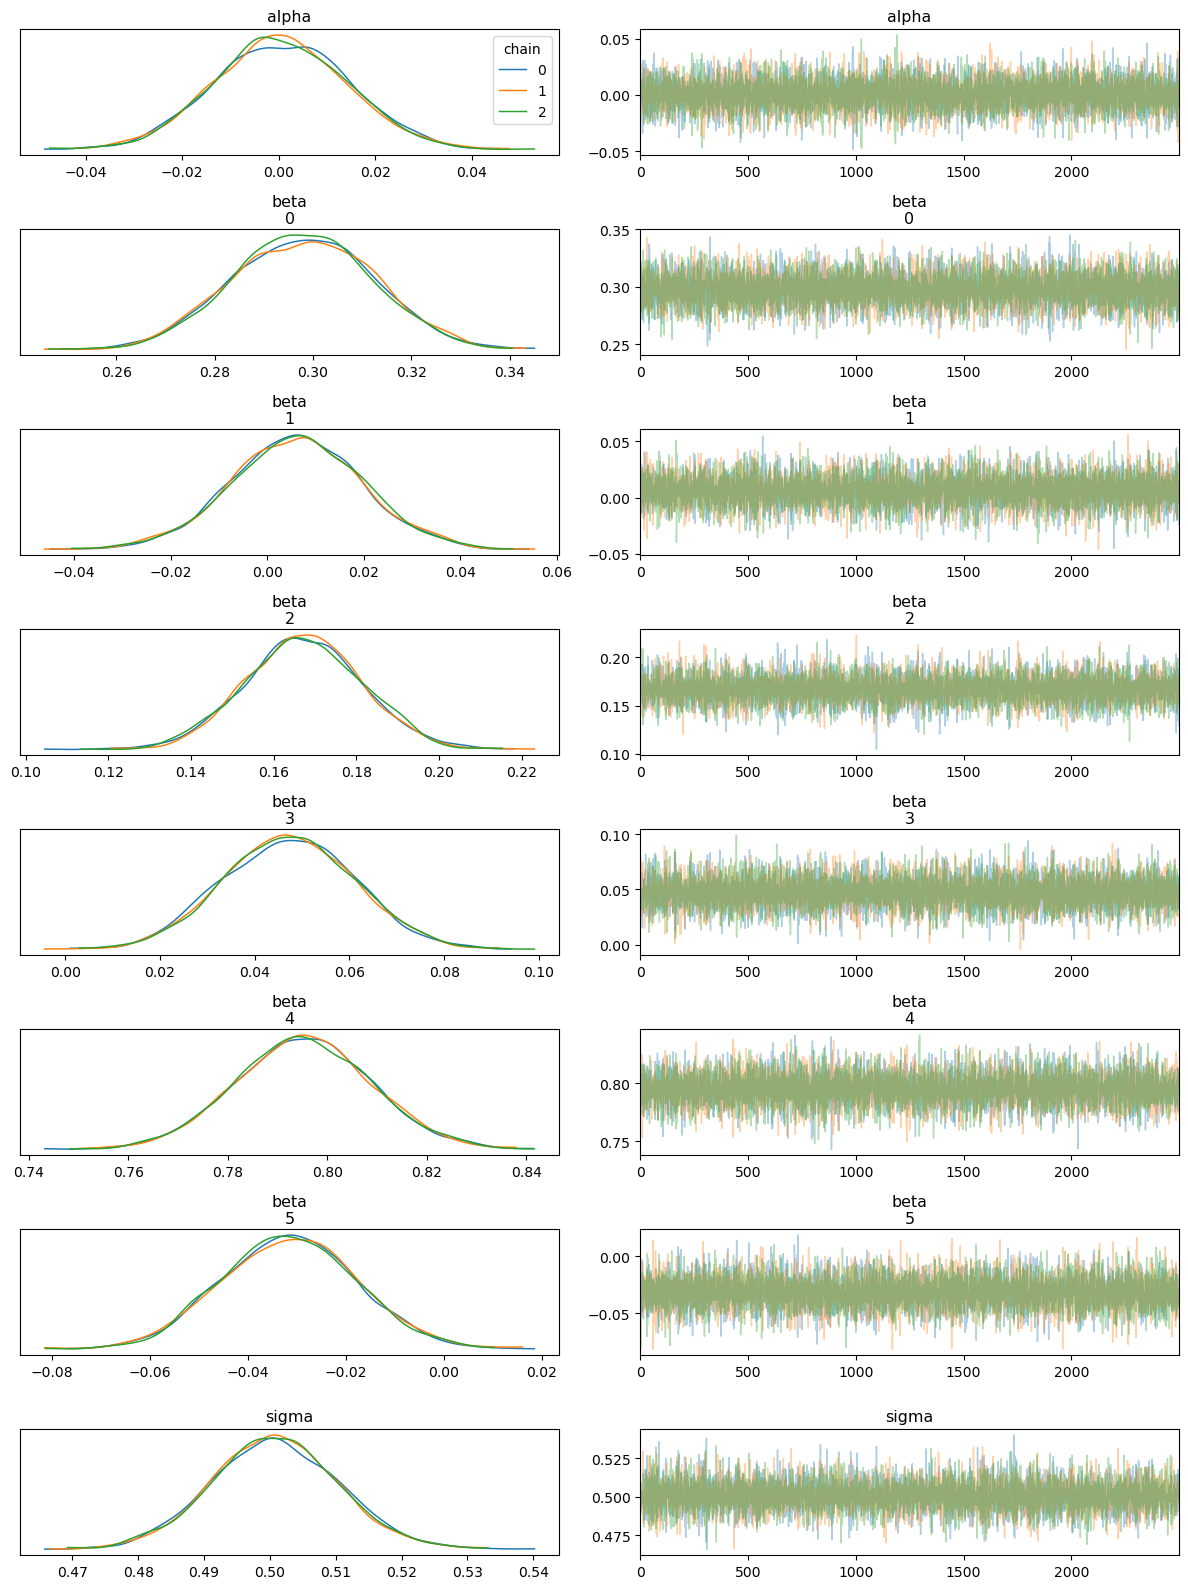

In [13]:
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()